In [2]:
from src.visualisation import PatientSnapshot

import SimpleITK as sitk
import sys
import time
import os
import numpy as np
import matplotlib.pyplot as plt

# Misc

In [3]:
def myshow(img, title=None, margin=0.05, dpi=80):
    nda = sitk.GetArrayViewFromImage(img)
    spacing = img.GetSpacing()
        
    if nda.ndim == 3:
        # fastest dim, either component or x
        c = nda.shape[-1]
        
        # the the number of components is 3 or 4 consider it an RGB image
        if not c in (3,4):
            nda = nda[nda.shape[0]//2,:,:]
    
    elif nda.ndim == 4:
        c = nda.shape[-1]
        
        if not c in (3,4):
            raise Runtime("Unable to show 3D-vector Image")
            
        # take a z-slice
        nda = nda[nda.shape[0]//2,:,:,:]
            
    ysize = nda.shape[0]
    xsize = nda.shape[1]
      
    # Make a figure big enough to accommodate an axis of xpixels by ypixels
    # as well as the ticklabels, etc...
    figsize = (1 + margin) * ysize / dpi, (1 + margin) * xsize / dpi

    fig = plt.figure(figsize=figsize, dpi=dpi)
    # Make the axis the right size...
    ax = fig.add_axes([margin, margin, 1 - 2*margin, 1 - 2*margin])
    
    extent = (0, xsize*spacing[1], ysize*spacing[0], 0)
    
    t = ax.imshow(nda,extent=extent,interpolation=None)
    
    if nda.ndim == 2:
        t.set_cmap("gray")
    
    if(title):
        plt.title(title)

In [4]:
def myshow3d(img, xslices=[], yslices=[], zslices=[], title=None, margin=0.05, dpi=80):
    size = img.GetSize()
    img_xslices = [img[s,:,:] for s in xslices]
    img_yslices = [img[:,s,:] for s in yslices]
    img_zslices = [img[:,:,s] for s in zslices]
    
    maxlen = max(len(img_xslices), len(img_yslices), len(img_zslices))
    
        
    img_null = sitk.Image([0,0], img.GetPixelID(), img.GetNumberOfComponentsPerPixel())
    
    img_slices = []
    d = 0
    
    if len(img_xslices):
        img_slices += img_xslices + [img_null]*(maxlen-len(img_xslices))
        d += 1
        
    if len(img_yslices):
        img_slices += img_yslices + [img_null]*(maxlen-len(img_yslices))
        d += 1
     
    if len(img_zslices):
        img_slices += img_zslices + [img_null]*(maxlen-len(img_zslices))
        d +=1
    
    if maxlen != 0:
        if img.GetNumberOfComponentsPerPixel() == 1:
            img = sitk.Tile(img_slices, [maxlen,d])
        #TO DO check in code to get Tile Filter working with vector images
        else:
            img_comps = []
            for i in range(0,img.GetNumberOfComponentsPerPixel()):
                img_slices_c = [sitk.VectorIndexSelectionCast(s, i) for s in img_slices]
                img_comps.append(sitk.Tile(img_slices_c, [maxlen,d]))
            img = sitk.Compose(img_comps)
            
    
    myshow(img, title, margin, dpi)

# Read (convert) data

In [17]:
# read raw data from file

reader = sitk.ImageSeriesReader()
dicom_names = reader.GetGDCMSeriesFileNames('../data/1')
reader.SetFileNames(dicom_names)
image = reader.Execute()

size = image.GetSize()
print( "Image size:", size[0], size[1], size[2] )

Image size: 512 512 1718


In [6]:
# # convert from Patient snapshot

# patient_path = '../data/1/'
# patient = PatientSnapshot.from_path(patient_path, mask_path=None)


# def writeSlices(series_tag_values, new_img, i):
#     image_slice = new_img[:,:,i]

#     # Tags shared by the series.
#     list(map(lambda tag_value: image_slice.SetMetaData(tag_value[0], tag_value[1]), series_tag_values))

#     # Slice specific tags.
#     image_slice.SetMetaData("0008|0012", time.strftime("%Y%m%d")) # Instance Creation Date
#     image_slice.SetMetaData("0008|0013", time.strftime("%H%M%S")) # Instance Creation Time

#     # Setting the type to CT preserves the slice location.
#     image_slice.SetMetaData("0008|0060", "CT")  # set the type to CT so the thickness is carried over

#     # (0020, 0032) image position patient determines the 3D spacing between slices.
#     image_slice.SetMetaData("0020|0032", '\\'.join(map(str,new_img.TransformIndexToPhysicalPoint((0,0,i))))) # Image Position (Patient)
#     image_slice.SetMetaData("0020,0013", str(i)) # Instance Number

#     # Write to the output directory and add the extension dcm, to force writing in DICOM format.
#     writer.SetFileName(os.path.join('../temp/',str(i)+'.dcm'))
#     writer.Execute(image_slice)

# img = sitk.GetImageFromArray(patient.snapshot.astype(np.int16))
# img.SetSpacing(patient.spacing)
# writer = sitk.ImageFileWriter()
# writer.KeepOriginalImageUIDOn()
# modification_time = time.strftime("%H%M%S")
# modification_date = time.strftime("%Y%m%d")
# direction = img.GetDirection()
# series_tag_values = [("0008|0031",modification_time), # Series Time
#                   ("0008|0021",modification_date), # Series Date
#                   ("0008|0008","DERIVED\\SECONDARY"), # Image Type
#                   ("0020|000e", "1.2.826.0.1.3680043.2.1125."+modification_date+".1"+modification_time), # Series Instance UID
#                   ("0020|0037", '\\'.join(map(str, (direction[0], direction[3], direction[6],# Image Orientation (Patient)
#                                                     direction[1],direction[4],direction[7])))),
#                   ("0008|103e", "Created-SimpleITK")] # Series Description
# list(map(lambda i: writeSlices(series_tag_values, img, i), range(img.GetDepth())))

# data_directory = '../temp/'
# series_IDs = sitk.ImageSeriesReader.GetGDCMSeriesIDs(data_directory)
# if not series_IDs:
#     print("ERROR: given directory \""+data_directory+"\" does not contain a DICOM series.")
#     sys.exit(1)
# series_file_names = sitk.ImageSeriesReader.GetGDCMSeriesFileNames(data_directory, series_IDs[0])

# series_reader = sitk.ImageSeriesReader()
# series_reader.SetFileNames(series_file_names)

# series_reader.LoadPrivateTagsOn()
# image3D = series_reader.Execute()
# print(image3D.GetSpacing(),'vs',img.GetSpacing())

In [9]:
image.GetSize()

(512, 512, 1718)

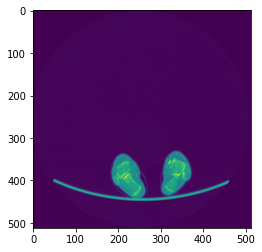

In [10]:
plt.imshow(sitk.GetArrayFromImage(image)[200, :, :])

## Fast marching cubes Segmentation

In [44]:
seedPosition = (240, 260)

sigma = float(0.5)
alpha = float(5.0)
beta = float(5.0)
timeThreshold = float(5.0)
stoppingTime = float(50.0)
# inputImage = sitk.ReadImage(inputFilename, sitk.sitkFloat32)
inputImage = image

inputImage = sitk.Cast(inputImage, sitk.sitkFloat32)


print(inputImage)

smoothing = sitk.CurvatureAnisotropicDiffusionImageFilter()
smoothing.SetTimeStep(0.125)
smoothing.SetNumberOfIterations(5)
smoothing.SetConductanceParameter(9.0)
smoothingOutput = smoothing.Execute(inputImage)

gradientMagnitude = sitk.GradientMagnitudeRecursiveGaussianImageFilter()
gradientMagnitude.SetSigma(sigma)
gradientMagnitudeOutput = gradientMagnitude.Execute(smoothingOutput)

sigmoid = sitk.SigmoidImageFilter()
sigmoid.SetOutputMinimum(0.0)
sigmoid.SetOutputMaximum(1.0)
sigmoid.SetAlpha(alpha)
sigmoid.SetBeta(beta)
sigmoid.DebugOn()
sigmoidOutput = sigmoid.Execute(gradientMagnitudeOutput)


fastMarching = sitk.FastMarchingImageFilter()
seedValue = 0
trialPoint = (seedPosition[0], seedPosition[1], seedValue)


fastMarching.AddTrialPoint(trialPoint)

fastMarching.SetStoppingValue(stoppingTime)

fastMarchingOutput = fastMarching.Execute(sigmoidOutput)


thresholder = sitk.BinaryThresholdImageFilter()
thresholder.SetLowerThreshold(0.0)
thresholder.SetUpperThreshold(timeThreshold)
thresholder.SetOutsideValue(0)
thresholder.SetInsideValue(255)

result = thresholder.Execute(fastMarchingOutput)

Image (0x7fbaf2a69880)
  RTTI typeinfo:   itk::Image<float, 2u>
  Reference Count: 1
  Modified Time: 120529
  Debug: Off
  Object Name: 
  Observers: 
    none
  Source: (none)
  Source output name: (none)
  Release Data: Off
  Data Released: False
  Global Release Data: Off
  PipelineMTime: 120521
  UpdateMTime: 120528
  RealTimeStamp: 0 seconds 
  LargestPossibleRegion: 
    Dimension: 2
    Index: [0, 0]
    Size: [512, 512]
  BufferedRegion: 
    Dimension: 2
    Index: [0, 0]
    Size: [512, 512]
  RequestedRegion: 
    Dimension: 2
    Index: [0, 0]
    Size: [512, 512]
  Spacing: [1, 1]
  Origin: [0, 0]
  Direction: 
1 0
0 1

  IndexToPointMatrix: 
1 0
0 1

  PointToIndexMatrix: 
1 0
0 1

  Inverse Direction: 
1 0
0 1

  PixelContainer: 
    ImportImageContainer (0x7fbaf2a69a20)
      RTTI typeinfo:   itk::ImportImageContainer<unsigned long, float>
      Reference Count: 1
      Modified Time: 120526
      Debug: Off
      Object Name: 
      Observers: 
        none
      Poin

In [45]:
sitk.WriteImage(result, './result.png')

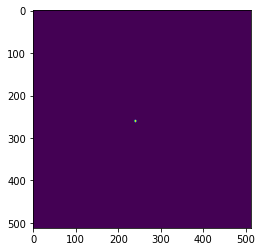

In [46]:
from PIL import Image
# Open the image form working directory
img = Image.open('result.png')
plt.imshow(img)

## Watershed Segmentation

In [18]:
# img = sitk.GetImageFromArray(patient.snapshot[-200].astype(np.int16))
img = sitk.GetImageFromArray(sitk.GetArrayFromImage(image)[1380])

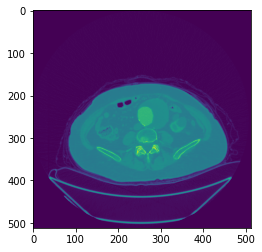

In [19]:
plt.imshow(sitk.GetArrayFromImage(img))

In [20]:
sigma=img.GetSpacing()[0]
level=4

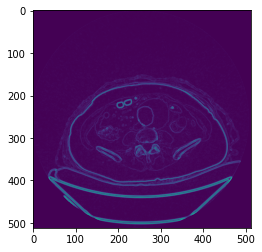

In [21]:
feature_img = sitk.GradientMagnitude(img)
plt.imshow(np.array(feature_img).reshape(512, 512))

In [22]:
min_img = sitk.RegionalMinima(feature_img, backgroundValue=0, foregroundValue=1.0, fullyConnected=False, flatIsMinima=True)
marker_img = sitk.ConnectedComponent(min_img)

In [23]:
pt = [240, 260]
idx = img.TransformPhysicalPointToIndex(pt)
marker_img *= 0
marker_img[0,0] = 1
marker_img[idx] = 2

ws = sitk.MorphologicalWatershedFromMarkers(feature_img, marker_img, markWatershedLine=True, fullyConnected=False)

In [26]:
ws.GetSize()

(512, 512)

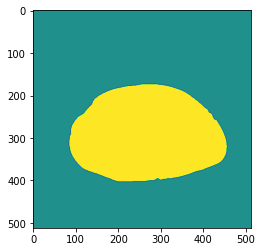

In [27]:
plt.imshow(sitk.GetArrayFromImage(ws))

# Level-set Segmentation

In [33]:
image.GetSize()
image = sitk.GetImageFromArray(sitk.GetArrayFromImage(image)[1380])

In [34]:
idx = (250, 255)
pt = image.TransformIndexToPhysicalPoint(idx)

In [35]:
seg = sitk.Image(image.GetSize(), sitk.sitkUInt8)
seg.CopyInformation(image)
seg[idx] = 1
seg = sitk.BinaryDilate(seg, 3)

In [36]:
stats = sitk.LabelStatisticsImageFilter()
stats.Execute(image, seg)
print(stats)

itk::simple::LabelStatisticsImageFilter
  UseHistograms: 1
  Labels: [ 0, 1 ]
  Debug: 0
  NumberOfThreads: 4
  Commands: (none)
  ProgressMeasurement: 0
  ActiveProcess:
    LabelStatisticsImageFilter (0x7fbaf2c646d0)
      RTTI typeinfo:   itk::LabelStatisticsImageFilter<itk::Image<short, 2u>, itk::Image<unsigned char, 2u> >
      Reference Count: 1
      Modified Time: 115705
      Debug: Off
      Object Name: 
      Observers: 
        DeleteEvent(SimpleMemberCommand)
      Inputs: 
        Primary: (0x7fbaf295aeb0) *
        _1: (0x7fbaf2b93b70)
      Indexed Inputs: 
        0: Primary (0x7fbaf295aeb0)
        1: _1 (0x7fbaf2b93b70)
      Required Input Names: Primary
      NumberOfRequiredInputs: 2
      Outputs: 
        Primary: (0x7fbaf2c649b0)
      Indexed Outputs: 
        0: Primary (0x7fbaf2c649b0)
      NumberOfRequiredOutputs: 1
      Number Of Threads: 4
      ReleaseDataFlag: Off
      ReleaseDataBeforeUpdateFlag: Off
      AbortGenerateData: Off
      Progress: 1
 

In [37]:
factor = 1.5
lower_threshold = stats.GetMean(1)-factor*stats.GetSigma(1)
upper_threshold = stats.GetMean(1)+factor*stats.GetSigma(1)

In [38]:
init_ls = sitk.SignedMaurerDistanceMap(seg, insideIsPositive=True, useImageSpacing=True)

In [39]:
lsFilter = sitk.ThresholdSegmentationLevelSetImageFilter()
lsFilter.SetLowerThreshold(lower_threshold)
lsFilter.SetUpperThreshold(upper_threshold)
lsFilter.SetMaximumRMSError(0.02)
lsFilter.SetNumberOfIterations(100)
lsFilter.SetCurvatureScaling(1)
lsFilter.SetPropagationScaling(1)
lsFilter.ReverseExpansionDirectionOn()
ls = lsFilter.Execute(init_ls, sitk.Cast(image, sitk.sitkFloat32))
print(lsFilter)

itk::simple::ThresholdSegmentationLevelSetImageFilter
  LowerThreshold: 293.935
  UpperThreshold: 518.713
  MaximumRMSError: 0.02
  PropagationScaling: 1
  CurvatureScaling: 1
  NumberOfIterations: 100
  ReverseExpansionDirection: 1
  ElapsedIterations: 100
  RMSChange: 0.174182
  Debug: 0
  NumberOfThreads: 4
  Commands: (none)
  ProgressMeasurement: 1
  ActiveProcess: (none)



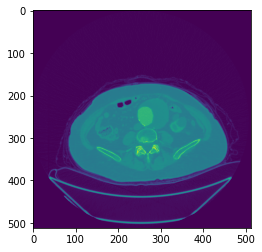

In [41]:
zslice_offset = 4
t = "LevelSet after "+str(lsFilter.GetNumberOfIterations())+" iterations"
plt.imshow(sitk.GetArrayFromImage(image))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

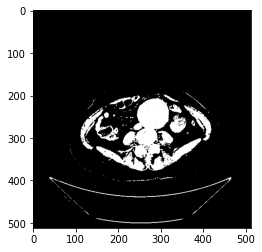

In [43]:
lsFilter.SetNumberOfIterations(25)
image = sitk.Cast(image, sitk.sitkFloat32)
ls = init_ls
niter = 0
for i in range(0, 10):
    ls = lsFilter.Execute(ls, image)
    niter += lsFilter.GetNumberOfIterations()
    t = "LevelSet after "+str(niter)+" iterations and RMS "+str(lsFilter.GetRMSChange())
#     fig = myshow3d(sitk.LabelOverlay(image, ls > 0), zslices=range(idx[2]-zslice_offset,idx[2]+zslice_offset+1,zslice_offset), dpi=20, title=t)
    plt.imshow(sitk.GetArrayFromImage(sitk.LabelOverlay(image, ls > 0)))